# Biologically Inspired Computation (F20BC/F21BC)

Clarence Deltel (ced2) <br />
H00330739 <br />

Dimitri Accad (dsa2) <br />
H00330740 <br />

### Import of the libraries

In [ ]:
import numpy as np
import pandas as pd
import os 
import random
from random import uniform
import numpy as np
import copy
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from mpl_toolkits import mplot3d


### Loading data

In [2]:
datafilelist = os.listdir('./Data')
datafilelist.sort()

all_data = {}

for i in datafilelist[0:4]:
    tmp_data = pd.read_csv("Data/"+i, delim_whitespace=True, header=None,names=["X", "Y"])
    all_data[i] = tmp_data
for i in datafilelist[4:]:    
    tmp_data = pd.read_csv("Data/"+i, delim_whitespace=True, header=None,names=["X", "Y","Z"])
    all_data[i] = tmp_data
    
print("\n",all_data.keys())


 dict_keys(['1in_cubic.txt', '1in_linear.txt', '1in_sine.txt', '1in_tanh.txt', '2in_complex.txt', '2in_xor.txt'])


### 1. Implemention of a multi-layer ANN architecture

First of all, we implemented different activation functions

In [3]:
def sigmoid(z):
    """
    Computes the sigmoid of z.
    """
    return (1.0/(1.0+np.exp(-z)))

def null(z):
    """
    Computes the Null of z.
    """
    return 0

def tanh(z):
    """
    Computes the Hyperbolic Tangent of z.
    """
    return np.tanh(z)

def cos(z):
    """
    Computes the Cosin of z.
    """
    return np.cos(z)

def gauss(z):
    """
    Computes the Gaussian of z.
    """
    return np.exp(-((z**2)/2))

def sin(z):
    """
    Computes the Gaussian of z.
    """
    return np.sin(z)


def reLU(z):
    size = z.shape
    for i in range (size[0]):
        for j in range (size[1]):
            if(z[i,j]<0):
                z[i,j]= 0
            elif(z[i,j]>= 0):
                z[i,j] = z[i,j]
    return z

function_list=["sigmoid","null","tanh","cos","gauss","sin","reLU"]
print("Function list :",function_list)

Function list : ['sigmoid', 'null', 'tanh', 'cos', 'gauss', 'sin', 'reLU']


#### Creation of the list of weight's matrix

In [4]:
def ThetaListGen(n_hidden_layer,n_neuron_layer,space_dim,D):
    ThetaList =[]
    for i in range (n_hidden_layer+1):
        if (i==0):#first layer
            #input dimension checking
            if(D==1):
                Theta=np.random.uniform(-space_dim,space_dim,(1,n_neuron_layer[i]))
                ThetaList.append(Theta)
            elif(D==2):
                Theta=np.random.uniform(-space_dim,space_dim,(2,n_neuron_layer[i]))
                ThetaList.append(Theta)
        if (i==n_hidden_layer): #last layer
            Theta=np.random.uniform(-space_dim,space_dim,(n_neuron_layer[i-1],1))
            ThetaList.append(Theta)
            return ThetaList
        elif (i != 0 and i!=n_hidden_layer):
            Theta=np.random.uniform(-space_dim,space_dim,(n_neuron_layer[i-1],n_neuron_layer[i]))
            ThetaList.append(Theta)

#### Flattening the weight list for the ANN Particule position

In [5]:
def MatrixFlattening(ThetaList):
    layer=len(ThetaList)
    vector_position=[]
    for i in range(layer):
        vector_position.extend(ThetaList[i].flatten())
    return vector_position

#### Rebuild of the weight list from the position vector

In [6]:
def MatrixConcentrate(flat,n_hidden_layer,n_neuron_layer,D):
    ThetaList =[]
    position1=0
    for i in range (n_hidden_layer+1):
        if (i==0):#first layer
            #input dimension checking
            if(D==1):
                position2=position1+n_neuron_layer[i]*1
                A = flat[position1:position2]
                Theta = np.reshape(A, (-1, n_neuron_layer[i]))
                ThetaList.append(Theta)
            elif(D==2):
                position2=position1+n_neuron_layer[i]*2
                A = flat[position1:position2]
                Theta = np.reshape(A, (2, n_neuron_layer[i]))
                ThetaList.append(Theta)
        if (i==n_hidden_layer):#last layer
            position1=position2
            position2=position1+n_neuron_layer[i-1]*1
            A = flat[position1:position2]
            Theta = np.reshape(A, (n_neuron_layer[i-1], -1))
            ThetaList.append(Theta)
            return ThetaList            
        elif (i != 0 and i!=n_hidden_layer):
            position1=position2
            position2=position1+n_neuron_layer[i]*n_neuron_layer[i-1]
            A = flat[position1:position2]
            Theta = np.reshape(A, (-1, n_neuron_layer[i]))
            ThetaList.append(Theta)        


#### ANN prediction from weight list, input and activation function : Feedforward propagation

In [7]:
def ANN(X,ThetaList,function,D):
    number_of_layer=len(ThetaList)
    g1=np.array(X)
    
    for i in range(number_of_layer):
        Theta=np.array(ThetaList[i])
        g1= globals()[function](np.dot(Theta.T,g1));
    #input dimension checking
    if (D==1):
        return g1[0][0]
    elif (D==2):
        return g1[0]

#### List of predictions

In [8]:
def getPredic (X_list,ThetaList,function,D):
    y_predict=[]
    #input dimension checking
    if (D==1):
        for i in X_list:
            y_predict.append(ANN(i,ThetaList,function,D))
    elif (D==2):
        X=X_list[0]
        Y=X_list[1]
        for i in range (len(X)):
            a= [X[i],Y[i]]
            y_predict.append(ANN(a,ThetaList,function,D))
            
    return y_predict

#### Mean square error

In [9]:
def MSE(y_true, y_predict ):
    MSE=0;
    for i in range (len(y_true)):
        MSE=MSE+((y_true[i]-y_predict[i])**2)
   
    MSE=MSE/len(y_true)

    return MSE

### 2. Implement a PSO algorithm

#### Hyper Parameter : PSO

In [10]:
swarmsize = 50
ret_velo = 0.5
ret_persoBest = 0.8
ret_informants = 0.5
ret_globalBest = 0.2
jumpSize = 0.5
precision_treshold = 0.0001 
max_iteration=50

#### Hyper Parameter : ANN

In [11]:
print("Activation function list : ",function_list)


Activation function list :  ['sigmoid', 'null', 'tanh', 'cos', 'gauss', 'sin', 'reLU']


In [12]:
space_dim = 3

n_neuron_layer = [6,5,4,3]
n_hidden_layer = len(n_neuron_layer)
activation_function = function_list[2]

#### Functions to predict

In [13]:
print("Data to predict : \n",all_data.keys())

Data to predict : 
 dict_keys(['1in_cubic.txt', '1in_linear.txt', '1in_sine.txt', '1in_tanh.txt', '2in_complex.txt', '2in_xor.txt'])


In [14]:
function_to_predict=all_data['1in_cubic.txt']
D=1

#### Class Particle

In [15]:
class Particle():

    def __init__(self):
        
        self.part_weight_matrix = ThetaListGen(n_hidden_layer,n_neuron_layer,space_dim,D)
        self.part_position = MatrixFlattening(self.part_weight_matrix)
        self.part_best_position = self.part_position 
        num_dim = len(self.part_position)
        self.part_velocity = np.random.uniform(-1,1,(1,num_dim))[0]
    def getBestPosition(self):
        return self.part_best_position
    def getCurrPosition(self):
        return self.part_position
    def getVelocity(self):
        return self.part_velocity
    
    def getFitness(self):
        #input dimension checking
        if (D==1):
            prediction = getPredic (function_to_predict["X"],self.part_weight_matrix,activation_function,D)
            fitness = MSE(function_to_predict["Y"], prediction )
        if(D==2):
            prediction = getPredic([function_to_predict["X"],function_to_predict["Y"]],self.part_weight_matrix,activation_function,D)
            fitness = MSE(function_to_predict["Z"], prediction )
        
        return fitness
    
    def getThetaMatrix(self):
        return self.part_weight_matrix 
        

#### The PSO algorithm
##### Initialization of the swarm

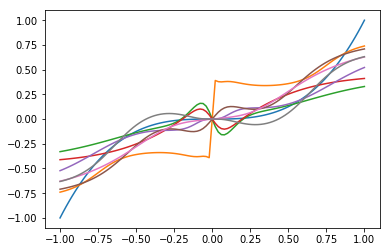

33  : best fitness : 0.01088735622426071
34  : best fitness : 0.01088735622426071
35  : best fitness : 0.01088735622426071
36  : best fitness : 0.01088735622426071
37  : best fitness : 0.01088735622426071
38  : best fitness : 0.01088735622426071
39  : best fitness : 0.01088735622426071
40  : best fitness : 0.01088735622426071
41  : best fitness : 0.01088735622426071
42  : best fitness : 0.01088735622426071
43  : best fitness : 0.01088735622426071
44  : best fitness : 0.01088735622426071
45  : best fitness : 0.01088735622426071
46  : best fitness : 0.01088735622426071
47  : best fitness : 0.01088735622426071
48  : best fitness : 0.01088735622426071
49  : best fitness : 0.01088735622426071
50  : best fitness : 0.01088735622426071


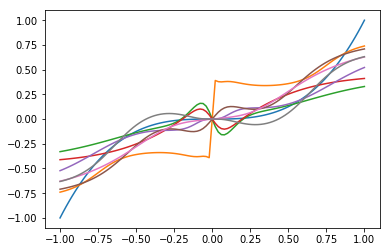

In [16]:
P=[]
for i in range(0,swarmsize):
    P.append(Particle())

gBest_fitness = float('inf') 
gBest_position = [None] * len(P[0].getCurrPosition())

%matplotlib inline
import time
import pylab as pl
from IPython import display

if (D==1):
    pl.plot(function_to_predict["X"],function_to_predict["Y"])
    display.clear_output(wait=True)
    display.display(pl.gcf())
    time.sleep(1.0)
    
if (D==2):
    ax = plt.axes(projection='3d')
    ax.plot3D(function_to_predict["X"], function_to_predict["Y"], function_to_predict["Z"], 'o')#,function_to_predict["X"], function_to_predict["Y"], function_to_predict["Z"], '-o')
    display.clear_output(wait=True)
    display.display(pl.gcf())
    time.sleep(1.0)
    
old_y=[]   
iteration=0

while (gBest_fitness > precision_treshold and iteration<max_iteration):
    #return gBest_position from all the particles
    for Particle_p in P:
        pFitness = Particle_p.getFitness() #assess fitness
        if gBest_fitness == float('inf') or pFitness < gBest_fitness:
            gBest_fitness = pFitness
            gBest_position = Particle_p.getBestPosition()
            BestParticle = copy.copy(Particle_p)
       
    for Particle_j in P:
        temp_list = P.copy()
        temp_list.remove(Particle_j)
        P_informants = random.choices(temp_list, k=5)
        P_informants.append(Particle_j)
        infoBest_fitness = float('inf')
        
        for Particle_i in P_informants:
            pFitness = Particle_i.getFitness() #calculate fitness between informants!
            if pFitness < infoBest_fitness:
                infoBest_fitness = pFitness
                infoBest_position = Particle_i.getBestPosition()
        
        vel_temp=[]
        for i in range(len(Particle_j.getCurrPosition())):
            b = uniform(0,ret_persoBest)
            c = uniform(0,ret_informants)
            d = uniform(0,ret_globalBest)

            
            new_vi = ret_velo*Particle_j.getVelocity()[i] + \
            b*(Particle_j.getBestPosition()[i]-Particle_j.getCurrPosition()[i]) + \
            c*(infoBest_position[i]-Particle_j.getCurrPosition()[i]) + \
            d*(gBest_position[i]-Particle_j.getCurrPosition()[i])
            
            vel_temp.append(new_vi)
            
        
        Particle_j.part_velocity = vel_temp
    
    
    for Particle_x in P:
        pos_temp = []
        for i in range(len(Particle_x.getCurrPosition())):
            new_po = Particle_x.getCurrPosition()[i] + jumpSize * Particle_x.getVelocity()[i]
            pos_temp.append(new_po)
        Particle_x.part_position = pos_temp
        Particle_x.part_weight_matrix = MatrixConcentrate(Particle_x.part_position,n_hidden_layer,n_neuron_layer,D)
        
    if (D==2):
        y_pred=getPredic([function_to_predict["X"],function_to_predict["Y"]],BestParticle.part_weight_matrix,activation_function,D) 
    elif (D==1):
        y_pred = getPredic (function_to_predict["X"],BestParticle.part_weight_matrix,activation_function,D)        
            
            
    print(iteration," : best fitness :",gBest_fitness)
    if(old_y != y_pred):
        if (D==1):
            pl.plot(function_to_predict["X"],y_pred)
            display.clear_output(wait=True)
            display.display(pl.gcf())
            old_y=y_pred.copy()
        if (D==2):
            ax.plot3D(function_to_predict["X"], function_to_predict["Y"], y_pred, '+')
            display.clear_output(wait=True)
            display.display(pl.gcf())
            old_y=y_pred.copy()
   
    iteration=iteration+1   

print(iteration," : best fitness :",gBest_fitness)

#### Graph of the predicted value from the best Particle

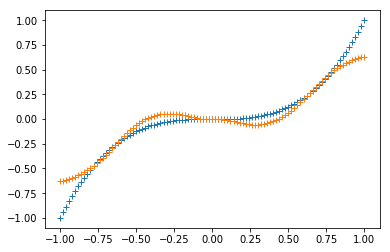

In [18]:
ThetaList=BestParticle.getThetaMatrix()
if (D==2):
    y_pred=getPredic([function_to_predict["X"],function_to_predict["Y"]],ThetaList,activation_function,D)
    plt.plot(function_to_predict["X"],function_to_predict["Z"],'+',function_to_predict["X"],y_pred,'+' )
    plt.show()
    plt.plot(function_to_predict["Y"],function_to_predict["Z"],'+',function_to_predict["Y"],y_pred,'+' )
    plt.show()
    ax = plt.axes(projection='3d')
    ax.plot3D(function_to_predict["X"], function_to_predict["Y"], function_to_predict["Z"], '+')#,function_to_predict["X"], function_to_predict["Y"], function_to_predict["Z"], '-o')
    ax.plot3D(function_to_predict["X"], function_to_predict["Y"], y_pred, '.')
    
elif (D==1):
    y_pred = getPredic (function_to_predict["X"],ThetaList,activation_function,D)
    plt.plot(function_to_predict["X"],function_to_predict["Y"],'+',function_to_predict["X"],y_pred,'+' )
    plt.show()